In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import os
import cv2

from keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
def detect(interpreter, input_tensor):
    """Runs detection on an input image.

    Args:
    interpreter: tf.lite.Interpreter
    input_tensor: A [1, input_height, input_width, 3] Tensor of type tf.float32.
      input_size is specified when converting the model to TFLite.

    Returns:
    A tensor of shape [1, 6, 56].
    """

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    is_dynamic_shape_model = input_details[0]['shape_signature'][2] == -1
    if is_dynamic_shape_model:
        input_tensor_index = input_details[0]['index']
        input_shape = input_tensor.shape
        interpreter.resize_tensor_input(input_tensor_index, input_shape, strict=True)
    interpreter.allocate_tensors()

    interpreter.set_tensor(input_details[0]['index'], input_tensor.numpy())

    interpreter.invoke()

    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

def keep_aspect_ratio_resizer(image, target_size):
    """Resizes the image.

    The function resizes the image such that its longer side matches the required
    target_size while keeping the image aspect ratio. Note that the resizes image
    is padded such that both height and width are a multiple of 32, which is
    required by the model.
    """
    _, height, width, _ = image.shape
    if height > width:
        scale = float(target_size / height)
        target_height = target_size
        scaled_width = math.ceil(width * scale)
        image = tf.image.resize(image, [target_height, scaled_width])
        target_width = int(math.ceil(scaled_width / 32) * 32)
    else:
        scale = float(target_size / width)
        target_width = target_size
        scaled_height = math.ceil(height * scale)
        image = tf.image.resize(image, [scaled_height, target_width])
        target_height = int(math.ceil(scaled_height / 32) * 32)
    image = tf.image.pad_to_bounding_box(image, 0, 0, target_height, target_width)
    return (image, (target_height, target_width))


In [3]:
img_folder=r'train'
starting_position = 110

In [4]:
def create_dataset():
    
    # Creating empty numpy array to fill it up with data 
    X = np.zeros((471, 336))
    y = np.zeros((471, 1))
    
    cnt = 0

    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            
            # reading images from training dataset and making it to fit format of model input
            image_path= os.path.join(img_folder, dir1,  file)
            input_size = 256
            image = tf.io.read_file(image_path)
            image = tf.compat.v1.image.decode_jpeg(image)
            image = tf.expand_dims(image, axis=0)

            # Resize and pad the image to keep the aspect ratio and fit the expected size.
            resized_image, image_shape = keep_aspect_ratio_resizer(image, input_size)
            image_tensor = tf.cast(resized_image, dtype=tf.uint8)

            interpreter = tf.lite.Interpreter(model_path='model.tflite')

            # Output: [1, 6, 56] tensor that contains keypoints/bbox/scores.
            keypoints_with_scores = detect(interpreter, tf.cast(image_tensor, dtype=tf.uint8))

            keypoints_with_scores = keypoints_with_scores.flatten()

            X[cnt] = keypoints_with_scores.copy()
            y[cnt] = int((dir1 == "falling"))
            cnt+=1
    return X, y

In [5]:
# Implementing dataset into Python environment
X, y = create_dataset()
print(X)
print(y)

[[0.25924683 0.51013267 0.26444194 ... 0.86230898 0.49836645 0.        ]
 [0.24099879 0.44071344 0.33850431 ... 0.68540829 0.16293217 0.        ]
 [0.3184084  0.32708314 0.27403653 ... 0.1552151  0.5677883  0.        ]
 ...
 [0.1642272  0.62706959 0.53718555 ... 0.88556653 0.60925913 0.        ]
 [0.19951229 0.68017668 0.61106759 ... 0.26359597 0.90573311 0.        ]
 [0.24023333 0.71197218 0.5256747  ... 0.26882598 0.04842146 0.        ]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.

In [6]:
# Making and compiling model 
final_model = Sequential()

final_model.add(Dense(120, input_dim=336, activation='relu'))
final_model.add(Dense(80, activation='relu'))
final_model.add(Dense(40, activation='relu'))
final_model.add(Dense(20, activation='relu'))
final_model.add(Dense(10, activation='relu'))
final_model.add(Dense(4, activation='relu'))
final_model.add(Dense(1, activation='sigmoid'))

final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
# Model summary
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               40440     
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 40)                3240      
                                                                 
 dense_3 (Dense)             (None, 20)                820       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 4)                 44        
                                                                 
 dense_6 (Dense)             (None, 1)                 5

In [8]:
# Training model
final_model.fit(X,y, epochs=10)

Epoch 1/10
15/15 [==============================] - 1s 4ms/step - loss: 0.5906 - accuracy: 0.7452
Epoch 2/10
15/15 [==============================] - 0s 2ms/step - loss: 0.4796 - accuracy: 0.8047
Epoch 3/10
15/15 [==============================] - 0s 2ms/step - loss: 0.4280 - accuracy: 0.8047
Epoch 4/10
15/15 [==============================] - 0s 3ms/step - loss: 0.3857 - accuracy: 0.8047
Epoch 5/10
15/15 [==============================] - 0s 2ms/step - loss: 0.3532 - accuracy: 0.8047
Epoch 6/10
15/15 [==============================] - 0s 2ms/step - loss: 0.3288 - accuracy: 0.8047
Epoch 7/10
15/15 [==============================] - 0s 3ms/step - loss: 0.3076 - accuracy: 0.8047
Epoch 8/10
15/15 [==============================] - 0s 3ms/step - loss: 0.2978 - accuracy: 0.8110
Epoch 9/10
15/15 [==============================] - 0s 3ms/step - loss: 0.2783 - accuracy: 0.8790
Epoch 10/10
15/15 [==============================] - 0s 3ms/step - loss: 0.2966 - accuracy: 0.8854


In [9]:
# Saving model weights
final_model.save('final_model.h5')

In [10]:
# Loading model weights
final_model = load_model('final_model.h5')

In [11]:
# Declaring function for passing image through MoveNet
def resize_image(image):
   
    X = np.zeros((1, 336))

    input_size = 256
    
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image)
    image = tf.expand_dims(image, axis=0)
    
    #print(image.shape)

    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    resized_image, image_shape = keep_aspect_ratio_resizer(image, input_size)
    image_tensor = tf.cast(resized_image, dtype=tf.uint8)

    interpreter = tf.lite.Interpreter(model_path='model.tflite')

    # Output: [1, 6, 56] tensor that contains keypoints/bbox/scores.
    keypoints_with_scores = detect(interpreter, tf.cast(image_tensor, dtype=tf.uint8))

    keypoints_with_scores = keypoints_with_scores.flatten()

    X[0] = keypoints_with_scores.copy()

    return X

1/1 [==============================] - 0s 31ms/step
falling


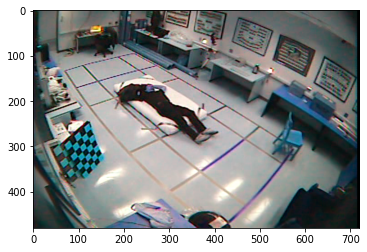

1/1 [==============================] - 0s 31ms/step
falling


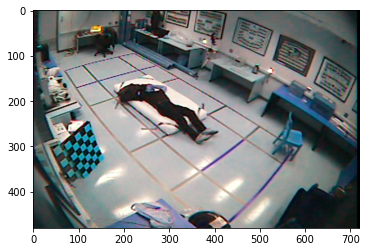

1/1 [==============================] - 0s 31ms/step
falling


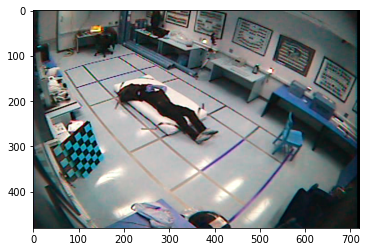

1/1 [==============================] - 0s 16ms/step
falling


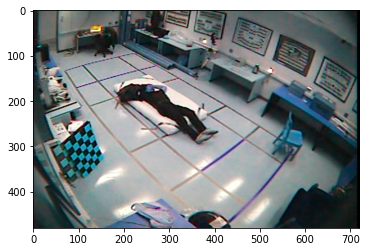

1/1 [==============================] - 0s 16ms/step
falling


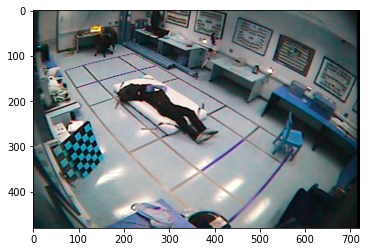

1/1 [==============================] - 0s 16ms/step
falling


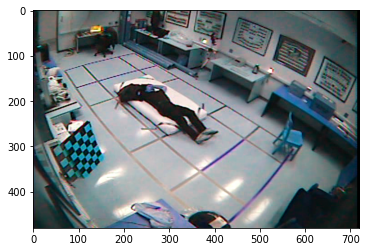

1/1 [==============================] - 0s 16ms/step
falling


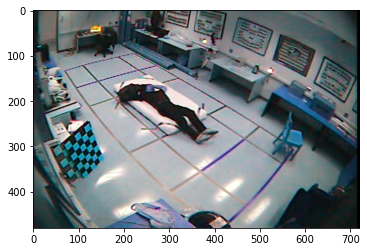

1/1 [==============================] - 0s 31ms/step
falling


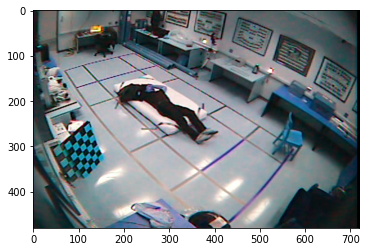

1/1 [==============================] - 0s 16ms/step
falling


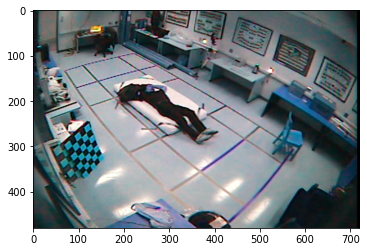

1/1 [==============================] - 0s 31ms/step
falling


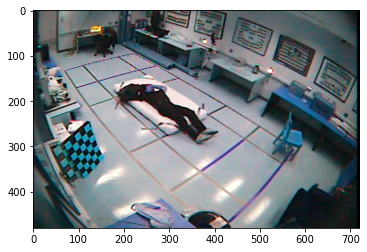

1/1 [==============================] - 0s 16ms/step
falling


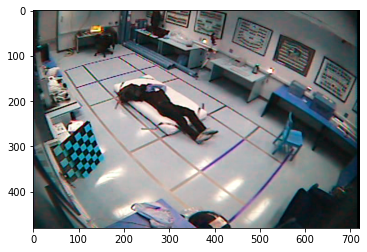

1/1 [==============================] - 0s 16ms/step
falling


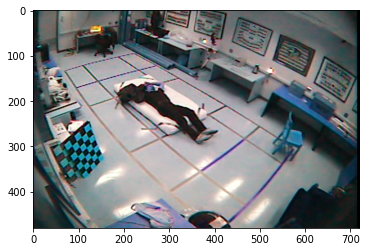

1/1 [==============================] - 0s 31ms/step
falling


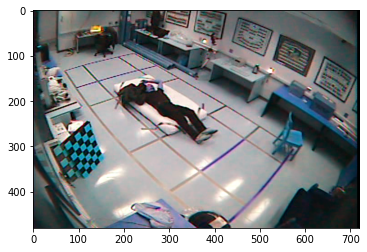

1/1 [==============================] - 0s 16ms/step
falling


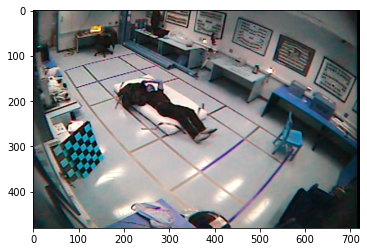

1/1 [==============================] - 0s 16ms/step
falling


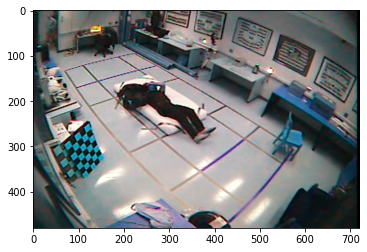

1/1 [==============================] - 0s 31ms/step
falling


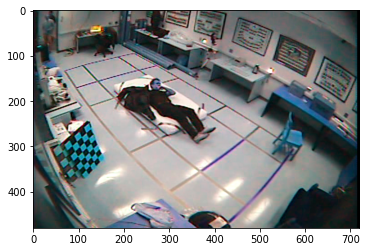

1/1 [==============================] - 0s 22ms/step
falling


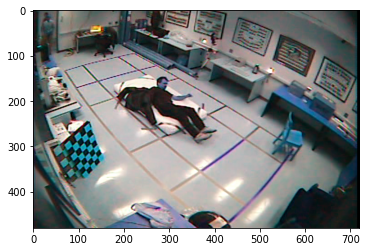

1/1 [==============================] - 0s 23ms/step


In [12]:
cap = cv2.VideoCapture("test.avi")

#print(cap.isOpened())
success = True

count = 0

cnt = 0

while success:
    success,image = cap.read()
    # save frame as JPEG file
    if count % 10 == 0 and success:
        filename = "frame%d.jpg" % count
        # Saving video frame into working environment folder
        cv2.imwrite(filename, image) 
        
        pred = final_model.predict(resize_image(filename))
        
        # Deleting video frame from working environment folder
        os.remove(filename)
        
        # Calculating how many times in the row was given result falling
        if(pred[0] >= 0.2):
            cnt += 1
        else:
            cnt = 0
        
        # If falling result was given more than 3 times, plot image
        if(cnt > 3):
            print("falling")
            plt.imshow(image)
            plt.show()
    count+=1
cap.release()